# Evaluation of an LSTM-AutoEncoder on the CERT Insider Threat Detection Dataset
# Kai Gomes, Zachary Lawton

Dependencies

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import datetime

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, LSTM, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import plot_model
from imblearn.under_sampling import RandomUnderSampler


## Load Dataset

Loads CERT v6.2 email dataset

In [2]:
# df = pd.read_csv("C:\\Users\\kaigo\\Downloads\\r6.2\\r6.2\\email.csv") #kai PC
df = pd.read_csv("D:\\r6.2\\email.csv") #zach pc
len(df)

10994957

Loads answers (malicious) for dataset and drops unecessary columns (all that aren't in email dataset)

In [3]:
# answers_df = pd.read_csv("C:\\Users\\kaigo\\Downloads\\answers\\answers\\r6.2-3.csv", header=None) #kai pc
answers_df = pd.read_csv("D:\\answers\\r6.2-3.csv", header=None)
answers_df = answers_df.where(answers_df[0] == 'email')
answers_df = answers_df[answers_df[0].notna()]
answers_df = answers_df.rename(columns={1: 'id', 2: "date", 3: "user", 4: "pc", 5: "to", 6: "cc", 7:"bcc", 8:"from", 9:"activity", 10:"size", 11: "attachment", 13: "content" })
answers_df = answers_df.drop([0, 12], axis=1)

Labels email data with malicious column

In [4]:
malicious_ids = answers_df['user'].unique()
df['malicious'] = [1 if x in malicious_ids else 0 for x in df['user']]

## Undersample data

Picks percentage of malicious data wanted and then scales non-malicious down to equal percentage

In [5]:
num_non_mal = len(df.loc[df['malicious'] == 0])
num_mal = len(df.loc[df['malicious'] == 1])
percent_want_mal = 0.1
num_non_mal_sample = num_non_mal - int(num_non_mal - (num_non_mal - (num_mal / percent_want_mal - num_mal)))
sample = df.loc[df['malicious'] == 0].sample(n = num_non_mal_sample, random_state=42).index.tolist()
df = df.drop(sample, axis=0)

In [6]:
print(num_mal, len(df) - num_mal)

90600 815400


## Feature Extraction

Gets number of words in message from message content

In [7]:
df['num_words'] = [len(x.split()) for x in df['content']]

Gets number of destinations, number of external destinations, and number of external destinations that appear in bcc:

In [8]:
df['num_dest'] = df.apply(lambda x: len(re.findall("(@)", x['to'] + ";" + (x['cc'] if not pd.isnull(x['cc']) else '') + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))), axis=1)

In [9]:
df['num_external'] = df.apply(lambda x: len(set(re.findall("(?<=@)[^.]+(?=.)", x['to'] + ";" + (x['cc'] if not pd.isnull(x['cc']) else '') + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))) - set(re.findall("(?<=@)[^.]+(?=.)", x['to']))), axis=1)

In [10]:
df['num_external_bcc'] =  df.apply(lambda x: len(set(re.findall("(?<=@)[^.]+(?=.)", x['to'] + ";" + (x['bcc'] if not pd.isnull(x['bcc']) else ''))) - set(re.findall("(?<=@)[^.]+(?=.)", x['to']))), axis=1)

Gets the number of attachments, total size of all attachments, number of different file types of attachments (.pdf, .doc, etc), and number of bcc recipients

In [11]:
df['num_attach'] = [len(x.split(";")) if type(x) == str else 0 for x in df['attachments']]

In [12]:
df['attach_size'] = [sum(map(int, re.findall("\(([^()]+)\)", x))) if type(x) == str else 0 for x in df['attachments']]

In [13]:
df['num_attach_type'] = [len(set(re.findall("\.(.*?)\(", x))) if type(x) == str else 0 for x in df['attachments']]

In [14]:
df['num_bcc'] = [len(x.split(";")) if type(x) == str else 0 for x in df['bcc']]

Creates a new dataframe with only the quantitative data that is able to be parsed

In [15]:
df = df[['date', 'num_dest','num_attach','num_attach_type', 'attach_size', 'num_external', 'num_external_bcc', 'size', 'num_words', 'num_bcc', 'malicious']]

Create y (malicious or not, not used in model itself since unsupervised)

In [16]:
y = df['malicious']
df = df.drop('malicious', axis=1)

## Normalize Data

Scale the features so that the model is more accurate (using `MinMaxScaler()`) and split into train/test data

In [17]:
dates = pd.to_datetime(df['date']).values
x = df.drop('date', axis=1).values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
# df['date'] = dates

## Create and Run Models

Split Data into train and test data: 66% train and 33% test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

### AutoEncoder

Creates model: encoder has 3 dense layers and 3 dropoout layers, repeat vector, and decoder has 3 dense layers and 3 dropoout layers

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0

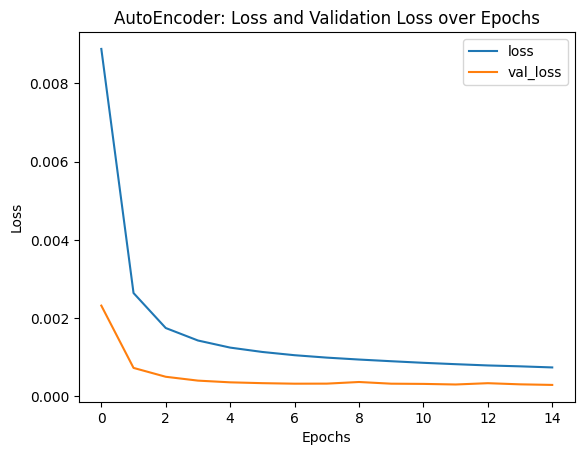

In [19]:
input_dim = X_train.shape[1] #num of predictor variables, 
encoding_dim = 2

# define model
model = Sequential()
model.add(Input(shape=(input_dim,)))
#encoder
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(32, activation='relu' ))
# model.add(RepeatVector(input_dim))
#decoder
model.add(Dense(32, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(X_train.shape[1], activation='relu'))
model.compile(optimizer='adam', loss='mse')
model.summary()
model
# fit model
history = model.fit(X_train, X_train, epochs=15, batch_size=10000, validation_data=(X_test, X_test))
# plot_model(model, show_shapes=True)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("AutoEncoder: Loss and Validation Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Predicts the values using the testing data

In [20]:
yhat = model.predict(X_test, verbose=0)

Calculates the anomoly score for each input in the testing data by the difference of the sum of the features and the predicted y value. Then established the anomoly cutoff based on the percentage of malicious datapoints in our sample and plots a histogram. This usually is done experimentally, but since we know the percentage of malicious in our dataset, we are able to evaluate the perfomance of the model.

Threshold: 0.10698431607953615


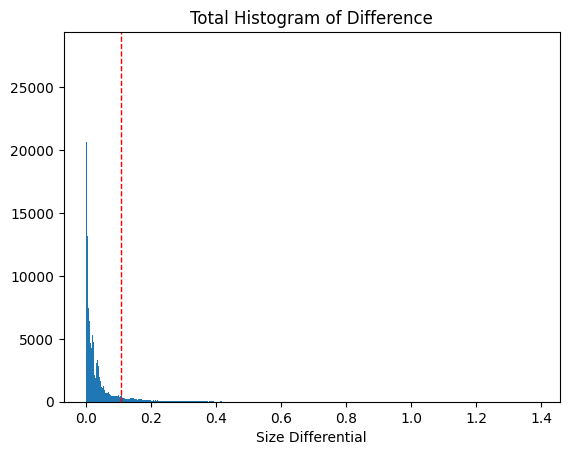

In [21]:
diff = [abs(x.sum() - y.sum()) for x, y in zip(X_test.to_numpy(), yhat)]
plot = plt.hist(diff, bins='auto')
plt.title("Total Histogram of Difference")
plt.xlabel("Size Differential")

i, total, percent = 0,0,0
while percent < .9:
    total+=plot[0][i]
    percent =  total / X_test.shape[0]
    i+=1
print("Threshold:", plot[1][i])
plt.axvline(plot[1][i], color='red', linestyle='dashed', linewidth=1)
plt.show()

Seperates the anomolies from the regular data using the threshold value

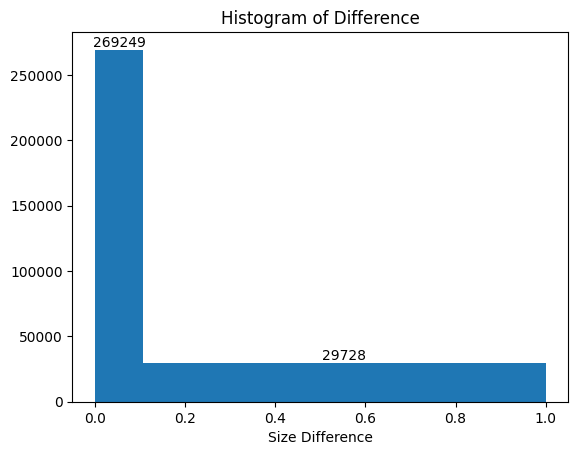

In [22]:
counts, edges, bars = plt.hist(diff,bins=[0,plot[1][i],1])
size_bar = plt.bar_label(bars)
plt.title("Histogram of Difference")
plt.xlabel("Size Difference")
plt.show()

In [23]:
diff

[0.06967658582094982,
 0.05000108162983996,
 0.001015858004743131,
 0.0066888019056555725,
 0.042367354594536444,
 0.04076156154475452,
 0.0037042552146062113,
 0.022204498680296614,
 0.048302010661049444,
 0.06291811135057124,
 0.0153680305150099,
 0.015265158434567605,
 0.05148530122024543,
 0.07553268129526325,
 0.056234902542640075,
 0.012025266498027626,
 0.00193406938164703,
 0.014553924553720399,
 0.0007534393751753021,
 0.0007156189219063025,
 0.07798334226482107,
 0.0052074560328240205,
 0.0022126263483019937,
 8.761567174983553e-05,
 0.000875174645505683,
 0.0024485670383538882,
 0.005437209677853105,
 0.019062974618477224,
 0.027950290082907392,
 0.023085099013886223,
 0.013070614309293127,
 0.009385175868191653,
 0.09836681061439156,
 0.00966025039158891,
 0.019702612472449643,
 0.03260387501974987,
 0.006501135679152836,
 0.0004076387469750531,
 0.003648621737580876,
 0.008718769847264607,
 0.043372543891456616,
 0.002981831718646577,
 0.002986140561229589,
 0.004735652201

In [24]:
threshold = plot[1][i]
thresh_classification = [0 if x < threshold else 1 for x in diff]

accuracy = sum([1 if i == j else 0 for i, j in zip(thresh_classification, y_test)]) / len(y_test)
accuracy

0.8212087765067898

### LSTM w/ timeseries

This creates timesteps that are 1 day apart. However, each day does not have an equal number of datapoints

In [25]:
# def get_days(x, i, current_time):
#     start_day = current_time
#     while current_time == start_day and i < len(x):
#         current_time = x.iloc[i]['date']
#         i+=1
#     return i, current_time


# def to_sequences(x, y):
#     x_values = []
#     y_values = []
#     current_time = x['date'].iloc[0]
#     end_time = x['date'].iloc[-1]
#     j = 0
#     while current_time <= end_time:
#         step, next_day = get_days(x,j,current_time)
#         if step < len(x):
#             x_values.append(x.iloc[j:step].values)
#             y_values.append(y.iloc[step])            
#             current_time = next_day
#         else:
#             x_values.append(x.iloc[j:step-1].values)
#             y_values.append(y.iloc[step-1])
#             break   
#         j=step
#     return np.array(x_values), np.array(y_values)

Seperates into equal siaed timesteps

In [27]:
def to_sequences_homogenous(x, y, seq_size=1):
    x_values = [x.iloc[i:(i+seq_size)].values for i in range(len(x)-seq_size)]
    y_values = [y.iloc[i:i+seq_size] for i in range(len(x)-seq_size)]
        
    return np.array(x_values), np.array(y_values)

Pick timesteps and split into train and test

In [28]:
# xtrain, ytrain = to_sequences(df, df.drop('date', axis=1))
X_timeseries, _ = to_sequences_homogenous(df, df, 50)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_timeseries, y[:-50], test_size=0.33, random_state=42)

C:\Users\zlaw6\AppData\Local\Temp\ipykernel_32648\2723171822.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  X_train, X_test, y_train, y_test = train_test_split(X_timeseries, y[:-50], test_size=0.33, random_state=42)


Creates model: encoder has 1 LSTM layer and dropoout layer, repeat vector, and decoder has 1 LSTM and dropout layer and then processes timeseries data with the TimeDistributed wrapper 

In [31]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(X_train.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               70656     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 50, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 50, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 50, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 9)            1161      
 ibuted)                                              

Fits model and calculates the losses

Creates model: encoder has 1 LSTM layer and dropoout layer, repeat vector, and decoder has 1 LSTM and dropout layer and then processes timeseries data with the TimeDistributed wrapper 

Epoch 1/10
12140/12140 [==============================] - 1190s 98ms/step - loss: 0.0413 - val_loss: 0.0403
Epoch 2/10
12140/12140 [==============================] - 1172s 97ms/step - loss: 0.0400 - val_loss: 0.0396
Epoch 3/10
12140/12140 [==============================] - 1179s 97ms/step - loss: 0.0395 - val_loss: 0.0389
Epoch 4/10
12140/12140 [==============================] - 1204s 99ms/step - loss: 0.0389 - val_loss: 0.0383
Epoch 5/10
12140/12140 [==============================] - 1204s 99ms/step - loss: 0.0385 - val_loss: 0.0378
Epoch 6/10
12140/12140 [==============================] - 1177s 97ms/step - loss: 0.0380 - val_loss: 0.0372
Epoch 7/10
12140/12140 [==============================] - 1166s 96ms/step - loss: 0.0376 - val_loss: 0.0365
Epoch 8/10
12140/12140 [==============================] - 1162s 96ms/step - loss: 0.0371 - val_loss: 0.0358
Epoch 9/10
12140/12140 [==============================] - 1164s 96ms/step - loss: 0.0366 - val_loss: 0.0352
Epoch 10/10
12140/12140 [===

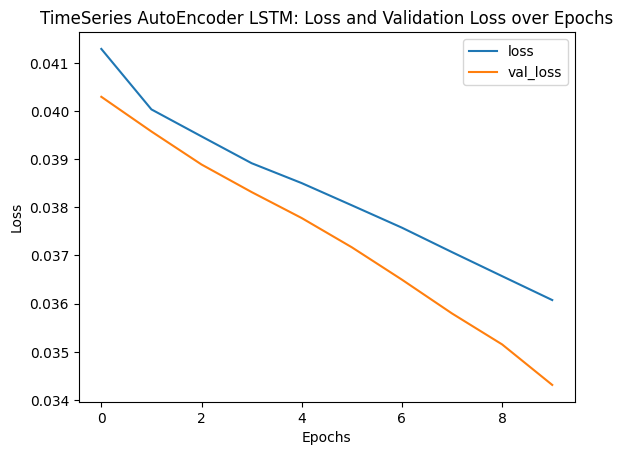

In [32]:
history = model.fit(X_train, X_train, epochs=10, batch_size=X_train.shape[1], validation_data=(X_test, X_test), verbose=1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("TimeSeries AutoEncoder LSTM: Loss and Validation Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Predicts the values using the testing data

In [33]:
yhat = model.predict(X_test, verbose=0)

Calculates the anomoly score for each input in the testing data by the difference of the sum of the features and the predicted y value. Then established the anomoly cutoff based on the percentage of malicious datapoints in our sample and plots a histogram. This usually is done experimentally, but since we know the percentage of malicious in our dataset, we are able to evaluate the perfomance of the model.

Threshold: 0.3229578652535313


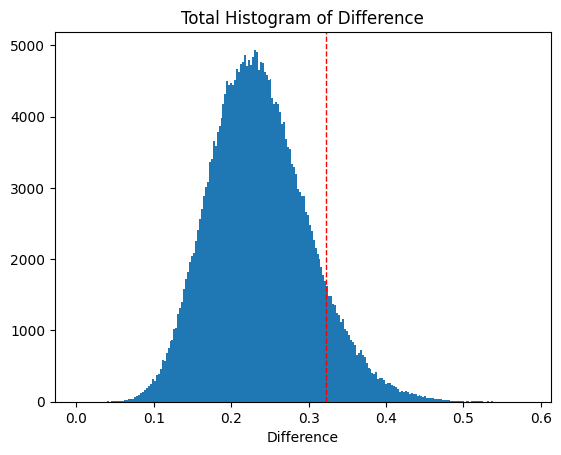

In [37]:
diff = [abs(x.sum() - y.sum())/X_test.shape[1] for x, y in zip(X_test, yhat)]
plot = plt.hist(diff, bins='auto')
plt.title("Total Histogram of Difference")
plt.xlabel("Difference")

i, total, percent = 0,0,0
while percent < .9:
    total+=plot[0][i]
    percent =  total / X_test.shape[0]
    i+=1
print("Threshold:", plot[1][i])
plt.axvline(plot[1][i], color='red', linestyle='dashed', linewidth=1)
plt.show()

Seperates the anomolies from the regular data using the threshold value

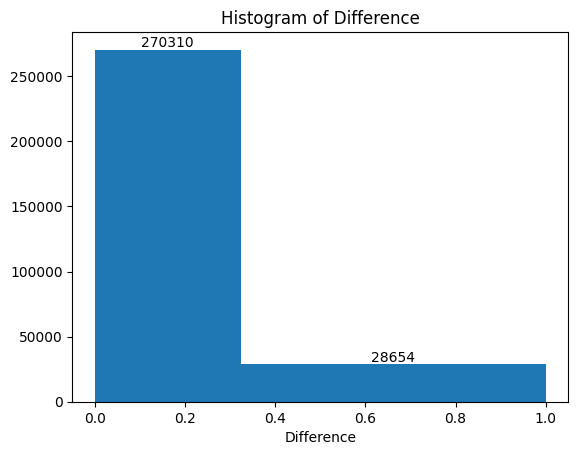

In [38]:
counts, edges, bars = plt.hist(diff,bins=[0,plot[1][i],1])
size_bar = plt.bar_label(bars)
plt.title("Histogram of Difference")
plt.xlabel("Difference")
plt.show()

In [36]:
threshold = plot[1][i]
thresh_classification = [0 if x < threshold else 1 for x in diff]

accuracy = sum([1 if i == j else 0 for i, j in zip(thresh_classification, y_test)]) / len(y_test)
accuracy

0.8227746484526565

### SVM

Splits data into test and training data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)

Creates OneClassSVM model since we want binary classification of the data. Using linear kernel because it is faster than RBF kernel. Additionally limits max_iterations to 20 for training time.

In [20]:
one_class_svm = OneClassSVM(nu=0.1, kernel = 'linear', gamma = 'auto', verbose=1, max_iter=20)

Fits data to model

In [21]:
one_class_svm.fit(X_train)

[LibSVM]

C:\Users\zlaw6\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


OneClassSVM(gamma='auto', kernel='linear', max_iter=20, nu=0.1, verbose=1)

In [22]:
ypred = one_class_svm.predict(X_test)

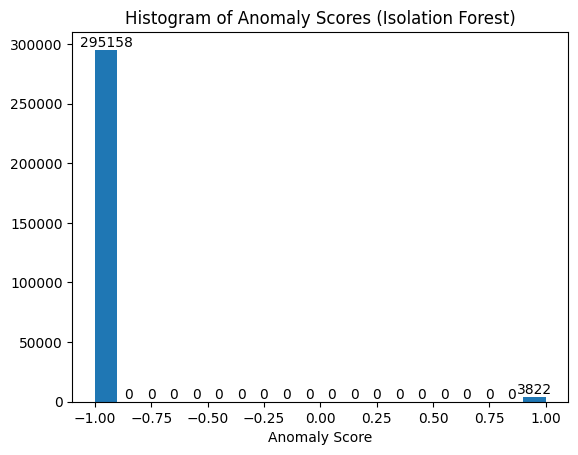

In [25]:
counts, edges, bars = plt.hist(ypred,bins='auto')
size_bar = plt.bar_label(bars)
plt.title("Histogram of Anomaly Scores (Isolation Forest)")
plt.xlabel("Anomaly Score")
plt.show()

In [26]:
converted_anomaly_scores = [0 if x == 1 else 1 for x in ypred]
print(classification_report(y_test, converted_anomaly_scores))

              precision    recall  f1-score   support

           0       0.89      0.01      0.02    269274
           1       0.10      0.99      0.18     29706

    accuracy                           0.11    298980
   macro avg       0.50      0.50      0.10    298980
weighted avg       0.81      0.11      0.04    298980



### Isolation Forest

Creates Isolation Forest model

In [101]:
model=IsolationForest(n_estimators=500,max_samples='auto',random_state=42,n_jobs=-1, max_features=9, verbose=True)

Trains model based on training data

In [102]:
model.fit(X_train)
print(model.get_params())

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:    4.5s remaining:   41.0s


{'bootstrap': False, 'contamination': 'auto', 'max_features': 9, 'max_samples': 'auto', 'n_estimators': 500, 'n_jobs': -1, 'random_state': 42, 'verbose': True, 'warm_start': False}


[Parallel(n_jobs=20)]: Done  20 out of  20 | elapsed:    4.7s finished


Predicts anomaly score and plots a histogram. Establishes threshold to classify data as malicious.

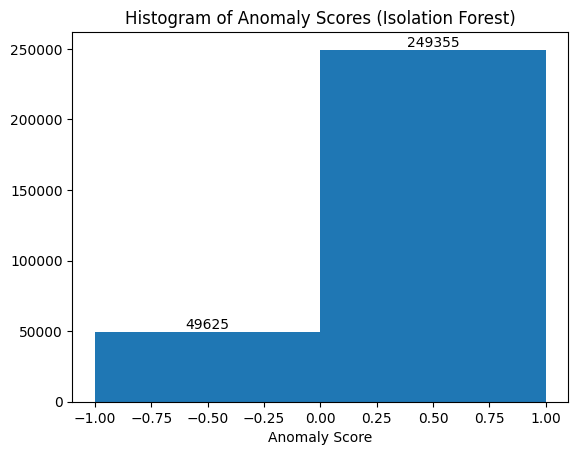

In [103]:
anomaly_scores = model.predict(X_test)
counts, edges, bars = plt.hist(anomaly_scores,bins=2)
size_bar = plt.bar_label(bars)
plt.title("Histogram of Anomaly Scores (Isolation Forest)")
plt.xlabel("Anomaly Score")
plt.show()

Uses the threshold to find accurracy of model.

In [104]:
converted_anomaly_scores = [0 if x == 1 else 1 for x in anomaly_scores]

In [105]:
thresh_classification = [0 if x < threshold else 1 for x in converted_anomaly_scores]
accuracy = sum([1 if i == j else 0 for i, j in zip(converted_anomaly_scores, y_test)]) / len(y_test)
accuracy

0.7682554016991103